# 3 ways to interpretate your NLP model to management and customer

![3 ways to interpretate your NLP model to management and customer](https://cdn.pixabay.com/photo/2017/02/22/20/02/landscape-2090495_960_720.jpg)

Photo: https://pixabay.com/en/landscape-fog-mood-sunrise-2090495/

Machine Learning (ML) and Artificial Intelligence (AI) changed the landscape in doing business. Lots of company hire data scientist (I am one of them:)) to deliver a data product. 

It is absolute easy to deliver a engine with "high" accuracy (Here is the reason why I double quoted). If somebody ask about reason, we can say that the model is black box or it is a statistical calculation few year ago but we cannot say that anymore nowadays. We also need to convince product team and management to trust our model but we cannot simply say that the engine "learnt" from data or it is a black box which cannot be explained as well.

Of course, we may not need to explain model in some special scenario. For example, you do not want to explain the fraud detection model to public. Otherwise, public can find a way to "hack" the system.

After reading this article, you will understand:
- What is model interpretation?
- Why do we need to interpretate model?
- Interpreting NLP model
- Take Away
- Reference

# What is model interpretation?
Model interpretation means providing reason and the logic behind in order to enable the accountability and transparency on model. There are many types of model interpretations which including:
- During exploratory data analysis (EDA), we may apply principal component analysis (PCA) or t-Distributed Stochastic Neighbor Embedding (t-SNE) to understand about the feature
- After built model, we will use various metric to measure classification and regression model. Accuracy, precision and recall used in classification while mean squared error (MSE) used in regression. This kind of metric help us to understand the model performance
- Besides performance, static feature summary such as feature importance can be retrieved from model. However, it only exist in those decision tree base algorithm such as Random Forest and XGBoost. 
- When evaluating model, we want to know why we predict it wrongly. We can leverage library to explain it so that we can fix it.

![](https://cdn.pixabay.com/photo/2015/07/17/22/43/whiteboard-849812_960_720.jpg)
Photo: https://pixabay.com/en/whiteboard-man-presentation-write-849812/

Before explaining the model, we can first understand the criteria of model interpretation: 
__Interpretability__
- Intrinsic: We do not need to train another model to explain the target. For example, it is using decision tree or liner model
- Post hoc: The model belongs to black-box model which we need to use another model to interpret it. We will focus on this area in the following part

__Approach__
- Model-specific: Some tools are limited to specific model such as liner model and neural network model.
- Model-agnostic: On the other hand, some tools able to explain any model by building write-box model. 

__Level__
- Global: Explain the overall model such as feature weight. This one give you a in general model behavior
- Local: Explain the specific prediction result.

# Why do we need to explain model?
As mentioned before, we should explain in most of the scenario because:
- Accountability. Model should has a accountability to provide a correct (relatively) answer to consumer. As a model author, we should validate model features to guarantee it help on make a correct decision but not including as much feature as we can.
- Transparency. Machine learning is not a black box and we should provide the model transparency to customer and management. So that they know why you are doing. Just like open source, people are willing to use open source much more as they know what you are doing.
- Trustability. It is the basic requirement if consumer want to use the classification or prediction result. Most of the time, use has some domain knowledge such as trader need to understand why you provide the decision for buy/ sell particular stock.

In [1]:
import random
import pandas as pd
import IPython
import xgboost
import keras

import eli5
from eli5.lime import TextExplainer
from lime.lime_text import LimeTextExplainer
print('ELI5 Version:', eli5.__version__)
print('XGBoost Version:', xgboost.__version__)
print('Keras Version:', keras.__version__)

Using TensorFlow backend.


ELI5 Version: 0.8
XGBoost Version: 0.7.post4
Keras Version: 2.1.5


In [2]:
from sklearn.datasets import fetch_20newsgroups
train_raw_df = fetch_20newsgroups(subset='train')
test_raw_df = fetch_20newsgroups(subset='test')

In [3]:
x_train = train_raw_df.data
y_train = train_raw_df.target

x_test = test_raw_df.data
y_test = test_raw_df.target

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

In [5]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from keras.models import Model, Input
from keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D, Bidirectional, concatenate
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

class KerasTextClassifier:
    __author__ = "Edward Ma"
    __copyright__ = "Copyright 2018, Edward Ma"
    __credits__ = ["Edward Ma"]
    __license__ = "Apache"
    __version__ = "2.0"
    __maintainer__ = "Edward Ma"
    __email__ = "makcedward@gmail.com"
    
    OOV_TOKEN = "UnknownUnknown"
    
    def __init__(self, 
                 max_word_input, word_cnt, word_embedding_dimension, labels, 
                 batch_size, epoch, validation_split,
                 verbose=0):
        self.verbose = verbose
        self.max_word_input = max_word_input
        self.word_cnt = word_cnt
        self.word_embedding_dimension = word_embedding_dimension
        self.labels = labels
        self.batch_size = batch_size
        self.epoch = epoch
        self.validation_split = validation_split
        
        self.label_encoder = None
        self.classes_ = None
        self.tokenizer = None
        
        self.model = self._init_model()
        self._init_label_encoder(y=labels)
        self._init_tokenizer()
        
    def _init_model(self):
        input_layer = Input((self.max_word_input,))
        text_embedding = Embedding(
            input_dim=self.word_cnt+2, output_dim=self.word_embedding_dimension,
            input_length=self.max_word_input, mask_zero=False)(input_layer)
        
        text_embedding = SpatialDropout1D(0.5)(text_embedding)
        
        bilstm = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.5))(text_embedding)
        x = concatenate([GlobalAveragePooling1D()(bilstm), GlobalMaxPooling1D()(bilstm)])
        x = Dropout(0.5)(x)
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.5)(x)
        
        output_layer = Dense(units=len(self.labels), activation="softmax")(x)
        model = Model(input_layer, output_layer)
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
        return model
    
    def _init_tokenizer(self):
        self.tokenizer = Tokenizer(
            num_words=self.word_cnt+1, split=' ', oov_token=self.OOV_TOKEN)
    
    def _init_label_encoder(self, y):
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(y)
        self.classes_ = self.label_encoder.classes_
        
    def _encode_label(self, y):
        return self.label_encoder.transform(y)
        
    def _decode_label(self, y):
        return self.label_encoder.inverse_transform(y)
    
    def _get_sequences(self, texts):
        seqs = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(seqs, maxlen=self.max_word_input, value=0)
    
    def _preprocess(self, texts):
        # Placeholder only.
        return [text for text in texts]
        
    def _encode_feature(self, x):
        self.tokenizer.fit_on_texts(self._preprocess(x))
        self.tokenizer.word_index = {e: i for e,i in self.tokenizer.word_index.items() if i <= self.word_cnt}
        self.tokenizer.word_index[self.tokenizer.oov_token] = self.word_cnt + 1
        return self._get_sequences(self._preprocess(x))
        
    def fit(self, X, y):
        """
            Train the model by providing x as feature, y as label
        
            :params x: List of sentence
            :params y: List of label
        """
        
        encoded_x = self._encode_feature(X)
        encoded_y = self._encode_label(y)
        
        self.model.fit(encoded_x, encoded_y, 
                       batch_size=self.batch_size, epochs=self.epoch, 
                       validation_split=self.validation_split)
        
    def predict_proba(self, X, y=None):
        encoded_x = self._get_sequences(self._preprocess(X))
        return self.model.predict(encoded_x)
    
    def predict(self, X, y=None):
        y_pred = np.argmax(self.predict_proba(X), axis=1)
        return self._decode_label(y_pred)

In [6]:
names = ['Logistic Regression', 'Random Forest', 'XGBoost Classifier', 'Keras']

In [9]:
def build_model(names, x, y):
    pipelines = []
    vec = TfidfVectorizer()
    vec.fit(x)

    for name in names:
        print('train %s' % name)
        
        if name == 'Logistic Regression':
            estimator = LogisticRegression(solver='newton-cg', n_jobs=-1)
            pipeline = make_pipeline(vec, estimator)
        elif name == 'Random Forest':
            estimator = RandomForestClassifier(n_jobs=-1)
            pipeline = make_pipeline(vec, estimator)
        elif name == 'XGBoost Classifier':
            estimator = XGBClassifier()
            pipeline = make_pipeline(vec, estimator)
        elif name == 'Keras':
            pipeline = KerasTextClassifier(
                max_word_input=100, word_cnt=30000, word_embedding_dimension=100, 
                labels=list(set(y_train.tolist())), batch_size=128, epoch=1, validation_split=0.1)
        
        
        pipeline.fit(x, y)
        pipelines.append({
            'name': name,
            'pipeline': pipeline
        })
        
    return pipelines, vec

In [10]:
pipelines, vec = build_model(names, x_train, y_train)

train Logistic Regression
train Random Forest
train XGBoost Classifier
train Keras
Train on 10182 samples, validate on 1132 samples
Epoch 1/1
10182/10182 [==============================] - 56s 6ms/step - loss: 2.9763 - acc: 0.0665 - val_loss: 2.8222 - val_acc: 0.0901


# Interpreting NLP model
As you know, I mainly focus on NLP. Therefore, I only demonstrate the capability of interpreting NLP model although the following library can also explain other problems such as regression and image.

For the following demonstration, I did NOT do any preprocessing for the sake of keeping it easy to understand. In real life business problem, we should do the preprocessing all the time. Otherwise, garbage in garbage out.

Several libraries helps to explain model which including Explain Like I am Five ([ELI5](https://medium.com/r/?url=https%3A%2F%2Fgithub.com%2FTeamHG-Memex%2Feli5)), Local Interpretable Model-agnostic Explanations ([LIME](https://medium.com/r/?url=https%3A%2F%2Fgithub.com%2Fmarcotcr%2Flime)) [1] and [Skater](https://medium.com/r/?url=https%3A%2F%2Fgithub.com%2Fdatascienceinc%2FSkater).
- Library: I will demonstrate how we can use ELI5 and LIME. How about Skater? Stay tuned, will explain reason why I do not use it in NLP. 
- Algorithm: In the following demonstration, it will include linear model (Logistic Regression in scikit-learn), ensemble model (Random Forest in scikit-learn, XGBoost) and deep learning model(self build word embedding in keras). For word embedding, you can check out my previous post for detail.

## ELI5

![](http://static.tumblr.com/c5a260708065789ef41ed2c4b9775b0c/hqljtju/Gg1nx44lz/tumblr_static_eqvnfxglppck44wg8o4ckk0go_2048_v2.png)
Photo: http://explain-like-i-am-five.tumblr.com/post/158611418472/eli5-the-concept-of-bankruptcy

ELI5 provides both global model interpretation and local model interpretation. You may simply consider the global model interpretation as a feature importance but it not only support decision tree algorithm such as Radom Forest and XGBoost but also all sci-kit learn estimators. 

ELI5 author introduces it as __Permutation Importance__ for global interpretation. To calculate the score, feature (a word) will be replaced by other word (noise) and predicting it. The idea is that feature importance [2]can be deduced by getting how much score decrease when a particular word is not provided. For example, "I like apple". It will may changed to "I like orange" and then it will classify the newly created record to understand how "apple" is important. Of course, we need to assume the replaced word (e.g. orange) is noise and it should not provide major change on score.

### ELI5 - Global Interpretation

In [11]:
for pipeline in pipelines:
    print('Estimator: %s' % (pipeline['name']))
    labels = pipeline['pipeline'].classes_.tolist()
    
    if pipeline['name'] in ['Logistic Regression', 'Random Forest']:
        estimator = pipeline['pipeline']
    elif pipeline['name'] == 'XGBoost Classifier':
        estimator = pipeline['pipeline'].steps[1][1].get_booster()
#     Not support Keras
#     elif pipeline['name'] == 'keras':
#         estimator = pipeline['pipeline']
    else:
        continue
    
    IPython.display.display(
        eli5.show_weights(estimator=estimator, top=10, target_names=labels, vec=vec))

Estimator: Logistic Regression


Estimator: Random Forest


Estimator: XGBoost Classifier


Estimator: Keras


The above figure means that, if input includes "keith", then score of y=0 increase 2.138. Another case is "the", it will decrease score -0.731 and -1.387 in y=1 and y=2 respectively

### ELI5 - Local Interpretation
For local model interpretation, ELI5 use LIME algorithm. The display format is different from LIME but using same idea.

In [12]:
number_of_sample = 1
sample_ids = [random.randint(0, len(x_test) -1 ) for p in range(0, number_of_sample)]

for idx in sample_ids:
    print('Index: %d' % (idx))
#     print('Index: %d, Feature: %s' % (idx, x_test[idx]))
    for pipeline in pipelines:
        print('-' * 50)
        print('Estimator: %s' % (pipeline['name']))
        
        print('True Label: %s, Predicted Label: %s' % (y_test[idx], pipeline['pipeline'].predict([x_test[idx]])[0]))
        labels = pipeline['pipeline'].classes_.tolist()
  
        if pipeline['name'] in ['Logistic Regression', 'Random Forest']:
            estimator = pipeline['pipeline'].steps[1][1]
        elif pipeline['name'] == 'XGBoost Classifier':
            estimator = pipeline['pipeline'].steps[1][1].get_booster()
        #     Not support Keras
#         elif pipeline['name'] == 'Keras':
#             estimator = pipeline['pipeline'].model
        else:
            continue

        IPython.display.display(
            eli5.show_prediction(estimator, x_test[idx], top=10, vec=vec, target_names=labels))

Index: 2504
--------------------------------------------------
Estimator: Logistic Regression
True Label: 6, Predicted Label: 1


--------------------------------------------------
Estimator: Random Forest
True Label: 6, Predicted Label: 5


--------------------------------------------------
Estimator: XGBoost Classifier
True Label: 6, Predicted Label: 1


--------------------------------------------------
Estimator: Keras
True Label: 6, Predicted Label: 6


ELI5 explains the test data and deciding that it may be y=0 and the probabilty is 0.031. It also highlight some high positive score and negative score words.

## LIME
![](https://www.weightlossresources.co.uk/pimg/wlr/l/lime-soda-article.jpg)
Credit: https://www.weightlossresources.co.uk/recipes/calorie-counted/drinks/lime-soda-1-pint-309537.htm

As the name mentioned, LIME focus on local model interpretable and model-agnostic part only. 

Passing trained model and target record to LIME library. A liner bag-of-words model will be created and providing lots of generated record for training a white box model. The while box model work as a __binary classifier indicating the impact of word existence__. For example, "I like apple". It will may changed to "I like" and then it will classify the newly created record to understand how "apple" is important.

So no matter what is the provided model is, it can also explain the model by generating records. No matter it is sci-kit learn library, XGBoost or even Kears word embedding model. In my sample code, I implemented Keras in scikit-learn API interface so that I can also use LIME to explain Keras's word embedding model.

### LIME - Local Interpretation

In [13]:
number_of_sample = 1
sample_ids = [random.randint(0, len(x_test) -1 ) for p in range(0, number_of_sample)]

for idx in sample_ids:
    print('Index: %d' % (idx))
#     print('Index: %d, Feature: %s' % (idx, x_test[idx]))
    for pipeline in pipelines:
        print('-' * 50)
        print('Estimator: %s' % (pipeline['name']))
        
        print('True Label: %s, Predicted Label: %s' % (y_test[idx], pipeline['pipeline'].predict([x_test[idx]])[0]))
        labels = pipeline['pipeline'].classes_.tolist()
        
        explainer = LimeTextExplainer(class_names=labels)
        exp = explainer.explain_instance(x_test[idx], pipeline['pipeline'].predict_proba, num_features=6, top_labels=5)
        IPython.display.display(exp.show_in_notebook(text=True))
        
#         break
#     break

Index: 99
--------------------------------------------------
Estimator: Logistic Regression
True Label: 16, Predicted Label: 10


/anaconda/envs/py35/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


None

--------------------------------------------------
Estimator: Random Forest
True Label: 16, Predicted Label: 3


None

--------------------------------------------------
Estimator: XGBoost Classifier
True Label: 16, Predicted Label: 7


None

--------------------------------------------------
Estimator: Keras
True Label: 16, Predicted Label: 6


None

LIME builds binary classifiers so we can see that it represent whether it is 0, 9, 15 classes with weight and highlighting high positive and negative score words

## Skater
![](https://cdn.pixabay.com/photo/2016/11/29/13/08/skateboard-1869727_960_720.jpg)
Photo: https://pixabay.com/en/skateboard-youth-skater-boy-skater-1869727/

For global interpretation, Skater provides feature importance and partial dependence approaches.

Tried several time and cannot find a way to provide sci-kit learn pipeline package. Have to convert raw text to numpy format and passing the model separately. Second thing is that it takes about 2 minutes to prepare the feature importance when there is about 800 unique words. 

### Skater - Global Interpretation

In [14]:
# Super slow when there is lots of feature(word in this case).......
pipelines, vec = build_model(names, x_train[:2], y_train[:2])

train Logistic Regression
train Random Forest
train XGBoost Classifier
train Keras
Train on 1 samples, validate on 1 samples
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 3.0256 - acc: 0.0000e+00 - val_loss: 2.9986 - val_acc: 0.0000e+00


--------------------------------------------------
Estimator: Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
[159/159] features ████████████████████ Time elapsed: 7 seconds

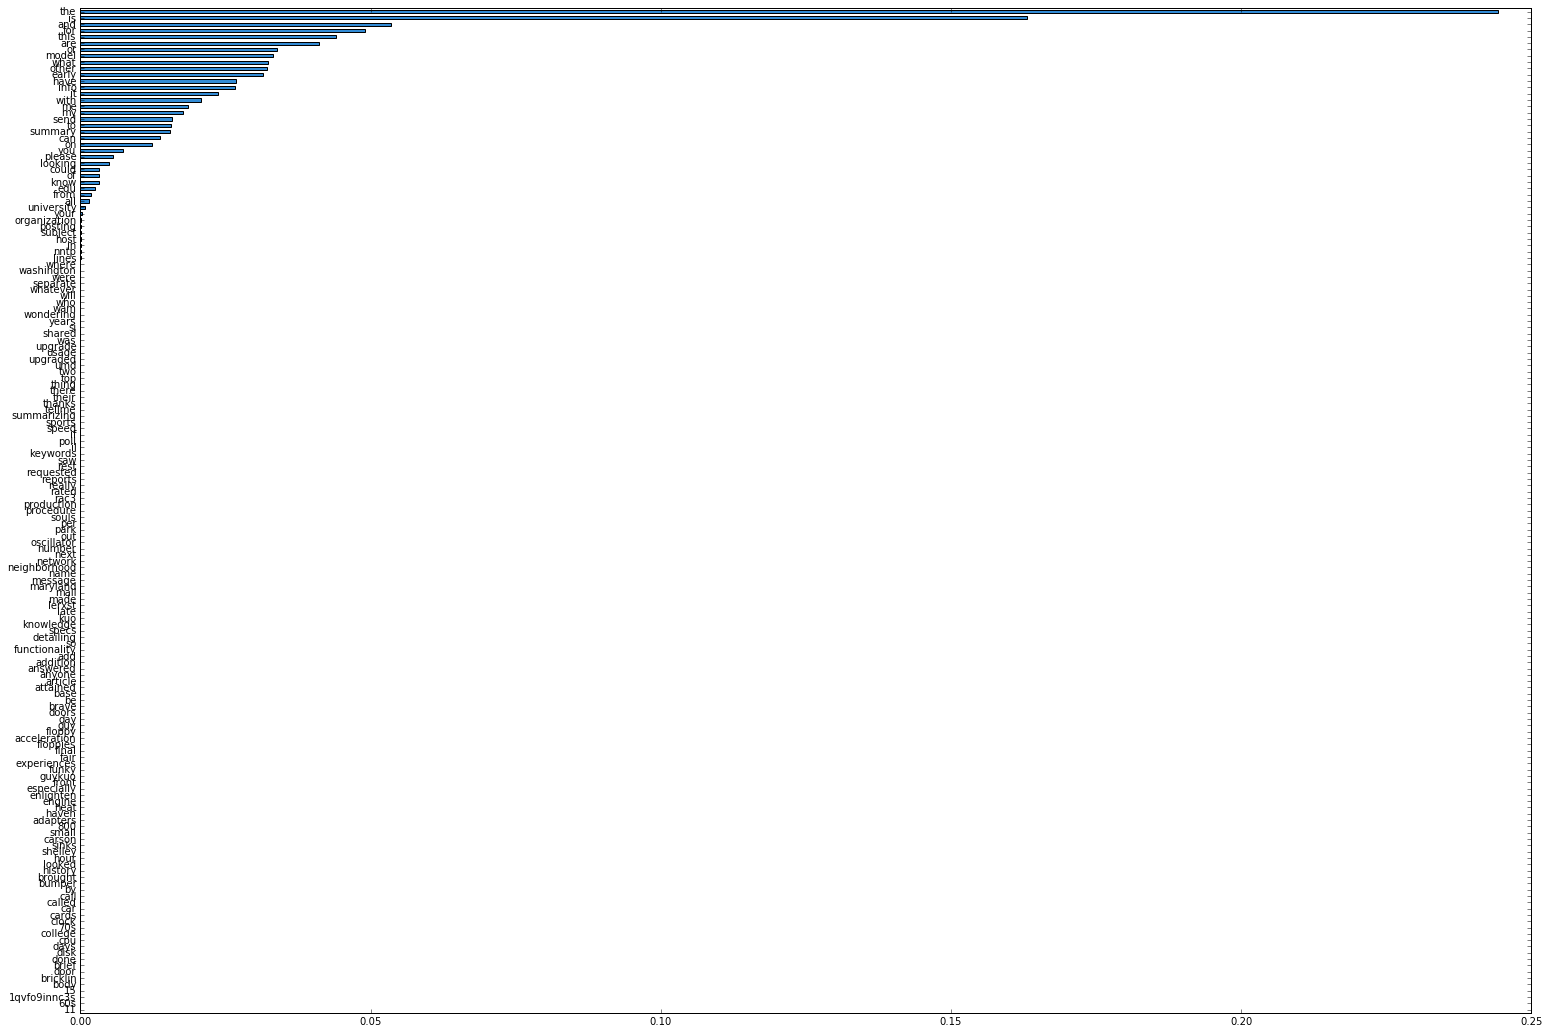

--------------------------------------------------
Estimator: Random Forest
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
[159/159] features ████████████████████ Time elapsed: 23 seconds

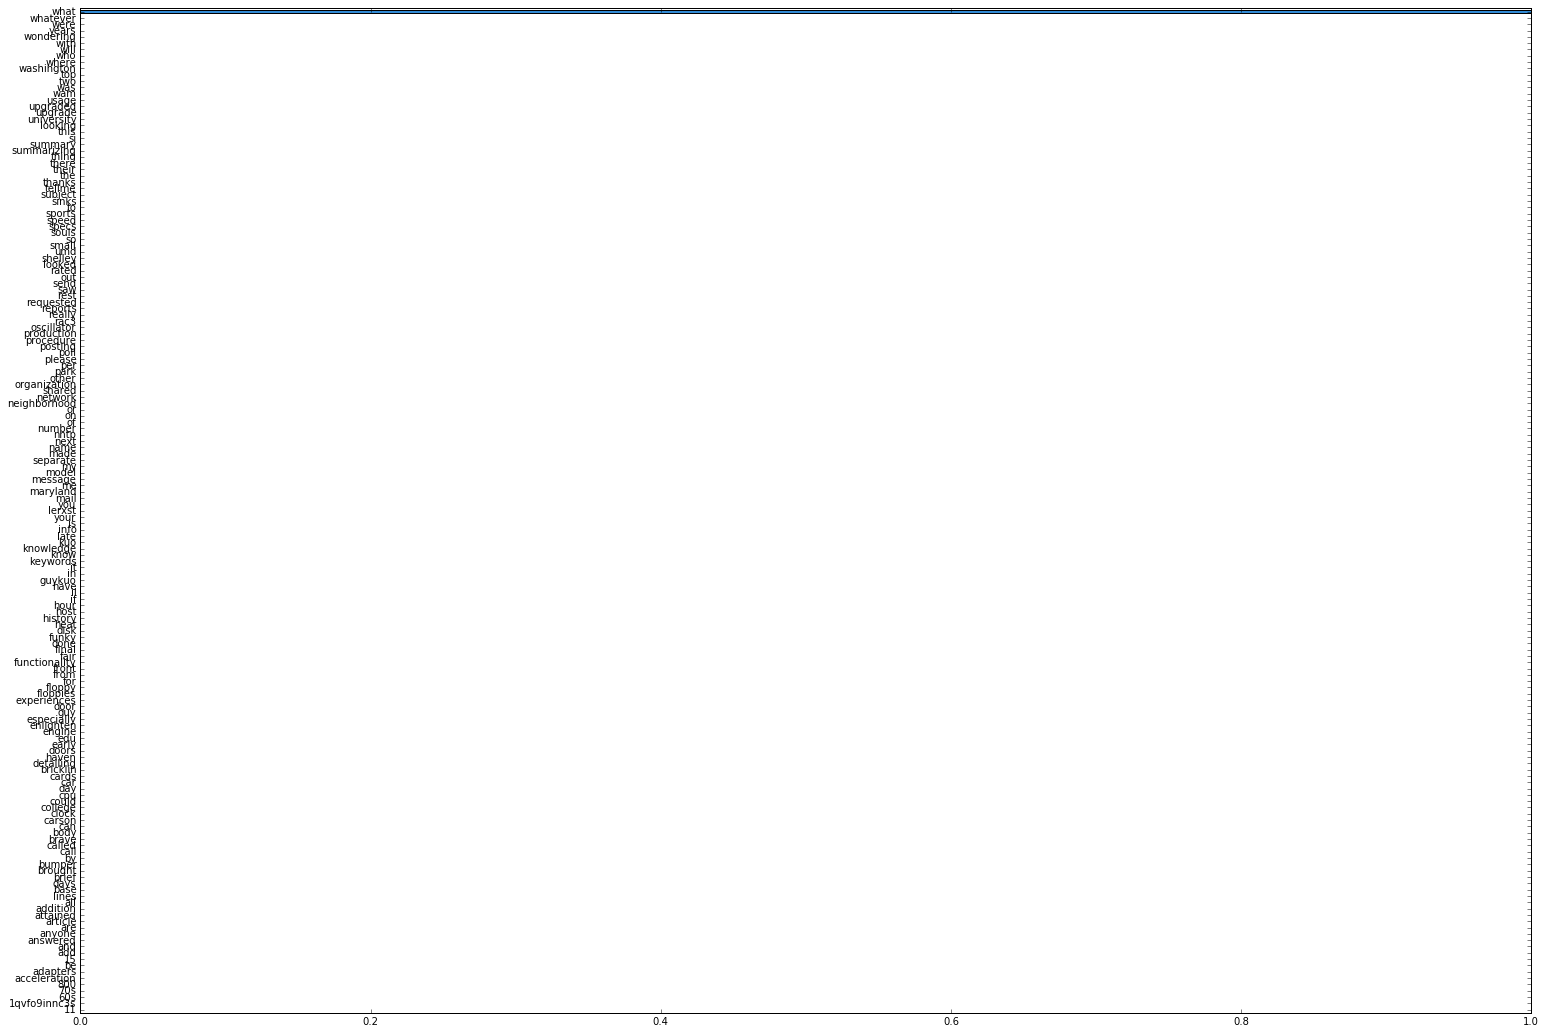

--------------------------------------------------
Estimator: XGBoost Classifier
--------------------------------------------------
Estimator: Keras


In [15]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from skater.model import InMemoryModel
from skater.core.explanations import Interpretation

transfromed_x_test = vec.transform(x_test[:2]).toarray()

interpreter = Interpretation(transfromed_x_test, feature_names=vec.get_feature_names())

for pipeline in pipelines:
    print('-' * 50)
    print('Estimator: %s' % (pipeline['name']))
    
    if pipeline['name'] in ['Logistic Regression', 'Random Forest']:
        estimator = pipeline['pipeline'].steps[1][1]
    else:
        continue
        
    print(estimator)
        
    pyint_model = InMemoryModel(estimator.predict_proba, examples=transfromed_x_test)
    
    f, axes = plt.subplots(1, 1, figsize = (26, 18))
    ax = axes
    interpreter.feature_importance.plot_feature_importance(pyint_model, ascending=False, ax=ax)
    plt.show()
    

Skater provides the feature importance per word.

### Skater - Local Interpretation

Partial dependence [3]is a bunch of figures to represent the relationship (linear, monotonic or complex) between target and features one by one. Providing a visualization, we can visualize the impact between one feature and target. However, we may not use partial dependency if there is NLP.

For local interpretation. [Skater](https://medium.com/r/?url=https%3A%2F%2Fgithub.com%2Fdatascienceinc%2FSkater%2Fblob%2Fmaster%2Fskater%2Fcore%2Flocal_interpretation%2Flime%2Flime_text.py) wraps LIME module to perform local Text Interpretation. So I will prefer to use native LIME rather than a pure wrapper.

# Take Away
You can access code via my github repo
- As a data scientist, we have to explain the model behavior so that __product team and management trust the deliverable__ and __debug your model__. Otherwise you may not know what you build.
- For NLP problem, feature importance or permutation feature importance are __demanding as too much features__ (word). Not quite useful/ recommend to use it in NLP aspect.
- LIME __do not able to explain the model correctly__ on some scenario. For example, the score can be different every time as it generates samples randomly. Will have another article to introduce how to resolve it.
- For ELI5, __sci-kit learn pipeline__ is supported in show_weight (Global Interpretation) but it is __not supported in show_prediction__ (Local Interpretation) in ELI5. Reason is mentioned in [here](https://medium.com/r/?url=https%3A%2F%2Fgithub.com%2FTeamHG-Memex%2Feli5%2Fissues%2F15). To overcome it, you can simply use LIME directly.
- There is [bug](https://medium.com/r/?url=https%3A%2F%2Fgithub.com%2FTeamHG-Memex%2Feli5%2Fissues%2F259) when using ELI5 (version: 0.8) if the classifier is __XGBoost Classifier. If you use XGBoost classifier, have to perform some workaround__ due to ELI5 bug (xgb_classifier.get_booster())
- For Keras model, implemented sci-kit learn API interface but still cannot use ELI5.

# Reference
[1] Marco Tulio Ribeiro, Sameer Singh, Carlos Guestrin. "Why Should I Trust You?" Explaining the Predictions of Any Classifier. Sep 2016. https://arxiv.org/pdf/1602.04938.pdf<br>
[2] Breiman Leo. " Random Forests".Jan 2001. https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf<br>
[3] Friedman, Jerome H. 2001. "Greedy Function Approximation: A Gradient Boosting Machine." Apr 2001. https://statweb.stanford.edu/~jhf/ftp/trebst.pdf<br>